In [1]:
import torch
from torch.autograd import Function
import torch.optim as optim

In [2]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,execute
from qiskit.circuit import Parameter
from qiskit import Aer
import numpy as np

/mnt/c/Users/dumon/Documents/Personal/quantum/ibm-qiskitcamp/qiskit-terra/qiskit/pulse/channels/pulse_channels.py:25: DeprecationWarning: Channels have been migrated. Please use `from qiskit.pulse.channels import X` rather than `from qiskit.pulse.channels.pulse_channels import X`.
  DeprecationWarning)


In [3]:
from tqdm import tqdm

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
np.random.seed = 42

In [6]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

class QiskitCircuit():
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.phi = Parameter('Phi')
        self.lam = Parameter('Lambda')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.u3(self.theta,self.phi,self.lam,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta,self.phi,self.lam] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=1000)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = 0.01
        
        forward_tensor, i = ctx.saved_tensors    
        input_numbers = to_numbers(i)
        gradient = [0,0,0]
        
        for k in range(len(input_numbers)):
            input_eps = input_numbers
            input_eps[k] = input_numbers[k] + eps

            exp_value = ctx.QiskitCirc.run(torch.tensor(input_eps))[0]
            result_eps = torch.tensor([exp_value])
            gradient_result = (exp_value - forward_tensor[0][0].item())/eps
            gradient[k] = gradient_result
            
#         print(gradient)
        result = torch.tensor([gradient])

        return result.float() * grad_output.float()

In [7]:
torch.manual_seed(42)

In [8]:
# # x = torch.tensor([np.pi/4, np.pi/4, np.pi/4], requires_grad=True)
# x = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# qc = TorchCircuit.apply
# y1 = qc(x)
# y1.backward()
# print(x.grad)

tensor([1.0000, 1.8000, 0.4000])


100%|██████████| 100/100 [00:06<00:00, 14.87it/s]


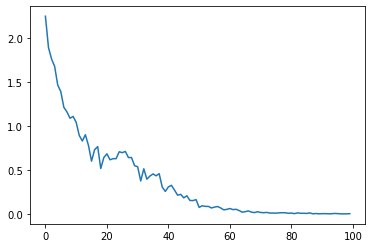

In [11]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)
    return torch.abs(qc(x) - target) ** 2, expval

x = torch.tensor([np.pi/4, np.pi/4, np.pi/4], requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval.item())
#     print(loss.item())

plt.plot(loss_list)
    
# print(circuit(phi, theta))
# print(cost(x))